# Basic imports
---

In [ ]:
# TODO: Add the necessary modules
import os, glob, random, shutil, csv
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
import cv2
import math
from PIL import Image

%matplotlib inline

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

# Download and process the data set
---



## Download from github

In [2]:
# !git clone https://github.com/octavio-navarro/DL_Data_sets.git

Cloning into 'DL_Data_sets'...
remote: Enumerating objects: 64973, done.
remote: Counting objects: 100% (504/504), done.
remote: Compressing objects: 100% (493/493), done.
remote: Total 64973 (delta 15), reused 497 (delta 11), pack-reused 64469 (from 1)
Receiving objects: 100% (64973/64973), 1.54 GiB | 9.29 MiB/s, done.
Resolving deltas: 100% (138/138), done.
Updating files: 100% (64453/64453), done.


## Show an image from the data set

(30, 30, 3)


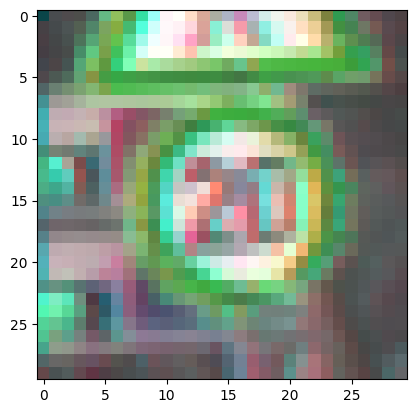

In [52]:
# TODO: Plot an image from the dataset using matplotlib
image = cv2.imread('C:\\Users\\calvo\\OneDrive\\Documentos\\TC3007C\\ComputerVision\\DL_Data_sets\\German_Traffic_signs\\Images\\00000\\00000_00001.ppm')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
print(image.shape)
plt.imshow(image)

## Separates the data into different folders

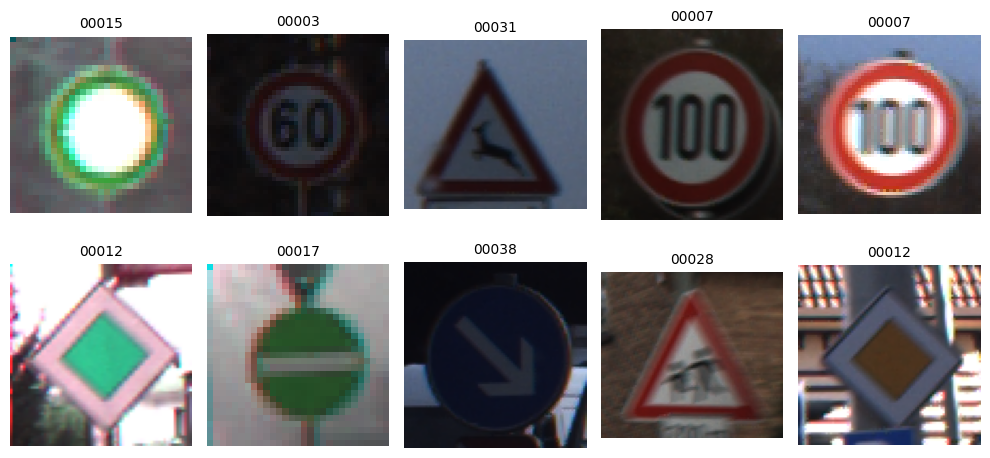

In [77]:
# TODO: Check out glob and copyfile, and create the test and train folders as needed. Each of the folders must have folders for each of the categories.
def separate_data(base_path, signal_dir, split_ratio=0.85):

    # Get complete signal directory path
    complete_signal_dir = os.path.join(base_path, signal_dir)

    # Iterate though each image
    file_names = []
    for root, _, files in os.walk(complete_signal_dir):
        for file in files:
            if file.endswith('.ppm'):
                file_names.append(os.path.join(root, file))

    # Shuffle the file names
    random.shuffle(file_names)

    # Split train and test sets
    split_idx = int(len(file_names) * split_ratio)
    train_images = file_names[:split_idx]
    test_images = file_names[split_idx:]

    train_labels = []
    test_labels = []

    for idx in range (len(train_images)):
        if idx <= split_idx:
            train_labels.append(signal_dir)
        else:
            test_labels.append(signal_dir)

    return train_images, test_images, train_labels, test_labels

"""
=================================
Generate train and test sets
=================================
"""

base_path = 'C:\\Users\\calvo\\OneDrive\\Documentos\\TC3007C\\ComputerVision\\DL_Data_sets\\German_Traffic_signs\\Images'
split_ratio = 0.85
train_images = []
test_images = []
train_labels = []
test_labels = []

# Iterate through each class directory
for class_ in os.listdir(base_path):
    # Separate data for the current class in train and test sets
    class_train, class_test, class_train_label, classs_test_label  = separate_data(base_path, signal_dir=class_, split_ratio=split_ratio)
    # Append to the overall train and test lists
    train_images.extend(class_train)
    test_images.extend(class_test)
    train_labels.extend(class_train_label)
    test_labels.extend(classs_test_label)

# Print 10 random train images with their class extracted from the file path
num_images = 10
selected = random.sample(train_images, num_images)  # elige 10 sin repetir

fig, axes = plt.subplots(2, 5, figsize=(10,5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img_path = selected[i]
    img_class = os.path.basename(os.path.dirname(img_path))

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    ax.set_title(img_class, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model definition with transfer learning
---

## Define a model to classify the images. **Use transfer learning for this step, but don't use fine-tuning.**


In [78]:
# TODO: Define a model to classify the images.
resnet_model = torch.hub.load("pytorch/vision", "resnet152", weights=None)

class CnnModel(L.LightningModule):
    def __init__(self, model, learning_rate, num_classes):
        """Initialize the CIFARCnnModel class.

            Args:
                model (torch.nn.Module): The CNN model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        # true_labels = true_labels - 1
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.

            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.

            Returns:
                torch.Tensor: Validation loss tensor
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            loss, true_labels, predicted_labels = self._shared_step(batch)
            self.test_acc(predicted_labels, true_labels)
            self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        return optimizer

Using cache found in C:\Users\calvo/.cache\torch\hub\pytorch_vision_main


## Define the data augmentation transformations for the data loaders.

In [79]:
# TODO: Add data augmentation

image_transforms = transforms.Compose([

        transforms.Resize((30, 30)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomRotation(45/2),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])

## Define the train, validation, and test dataloaders

In [80]:
# TODO: Create generators for training, validation, and testing.

class SignalsDatasets(Dataset):
    def __init__(self, file_dir, classes, transform=None):
        self.labels_df = file_dir
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df[idx]
        image = Image.open(img_path)

        label = self.classes[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = SignalsDatasets(train_images, train_labels, transform=image_transforms)
train_dataset, val_dataset = random_split(train_dataset, lengths=[len(train_images) - len(test_images), len(test_images)])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=25)

print(f'Training dataset: {len(train_dataset)}')
print(f'Validation dataset: {len(val_dataset)}')

print(f'Classes: {train_dataset.dataset.classes[0]}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Transform: {train_dataset.dataset.transform}')

Training dataset: 27427
Validation dataset: 5891
Classes: 00000
Classes: ['00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000', '00000',

## Using matplotlib, visualize images from the train dataloader. Create a figure of 20 images, with 5 images per row.

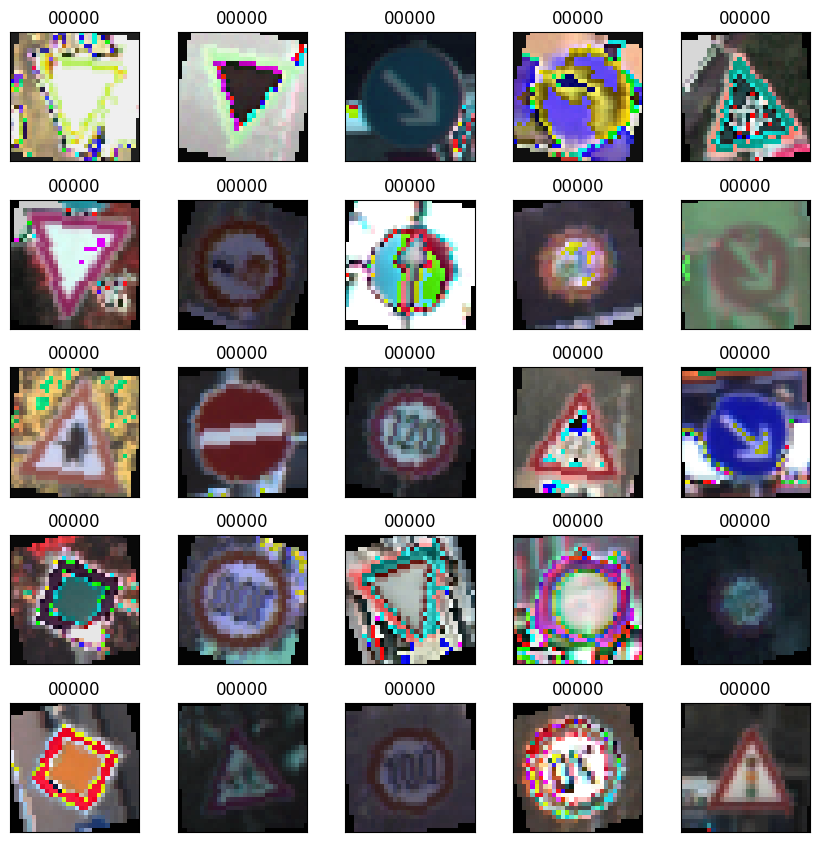

In [82]:
# TODO: Create a figure with images from the test generator.
train_batch = next(iter(train_dataloader))


f, ax = plt.subplots(5, 5, figsize=(10, 10))
f.tight_layout(pad=0.)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

for idx in range(25):
    row = idx // 5
    col = idx % 5

    image = train_batch[0][idx].numpy().transpose((1, 2, 0))
    image = (image * 255.0).astype("uint8")

    label_tensor = train_batch[1][idx]
    label_idx = int(label_tensor)

    ax[row, col].imshow(image)
    ax[row, col].set_title(train_dataset.dataset.classes[label_idx])
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])

plt.show()

## Train the model. Use model checkpoints and early stopping during training. **Don't forget to use a GPU for training.**

In [10]:
# TODO: Train the model.

## Model evaluation
---

### Evaluate the performance of the model with the test dataloader.

In [11]:
# TODO: Evaluate the model, and print the results.

### Plot the results of training: plot training and validation accuracy, and loss.

In [12]:
# TODO: Plot the results of the training and validation accuracy.

# TODO: Plot the results of the training and validation loss.

# Model using Transfer Learning and fine-tuning
---

Create a model using transfer learning, data augmentation, and fine-tuning, train the model, and do predictions with it on the test dataset.

## Make and train a new model using transfer learning and fine-tuning.


In [13]:
# TODO: Create a model using transfer learning

## Plot the results of training and evaluation

In [14]:
# TODO: Plot training and print the evaluation results

## Makes predictions using the test dataset

In [15]:
# TODO: Make predictions

# Compare the performance of both models
---

Plot the results of both models in the same figure.

In [16]:
# TODO: Plot the results of both datasets in the same figure.

# Test the models on new images
---

Download new images of traffic signs, and test both models on the images. Download at least 5 images. Plot them with the predicted class.

Add a text cell with your conclusions on the performance of the models on the new images.

## Download new images, and make predictions on them.

In [17]:
# TODO: Make predictions on new images.